In [17]:
import numpy as np
from netCDF4 import Dataset
from nco import Nco
import glob
import pyproj as proj

In [18]:
p1 = proj.Proj(proj='longlat',ellps='WGS84',datum='WGS84') # doms box projection

In [19]:
p2 = proj.Proj(proj='lcc',lat_1=28,lat_2=50,lat_0=39.700012207,
               lon_0=-98,x_0=0,y_0=0,a=6370000,b=6370000,units='m') # WRF hydro LCC projection

In [20]:
# dom's box coordinates in WGS84
bx_longs= np.array([-112.25,-104.125])
bx_lats = np.array([33.0,43.75])

In [21]:
bx_x,bx_y = proj.transform(p1,p2,bx_longs,bx_lats) # Convert WGS84 to WRF LCC projection

In [22]:
bx_x

array([-1306471.27248405,  -483968.19202259])

In [23]:
bx_y

array([-629423.95809243,  458859.27923162])

In [24]:
p3 = proj.Proj(proj='longlat',a=6370000,b=6370000) # WRF spherical lat lons

In [25]:
fl2 = './geo_em.d01.nc'
geo = Dataset(fl2,'r','NETCDF') # open the geogrid netCDFs

In [26]:
# extract lats and longs from the geogrid file
XLATS = geo['XLAT_M'][0]
XLONGS = geo['XLONG_M'][0]

In [27]:
X,Y = proj.transform(p3,p2,XLONGS,XLATS) # project lats and longs into WRF LCC

(-3000000.0, 3000000.0, -3000000.0, 3000000.0)

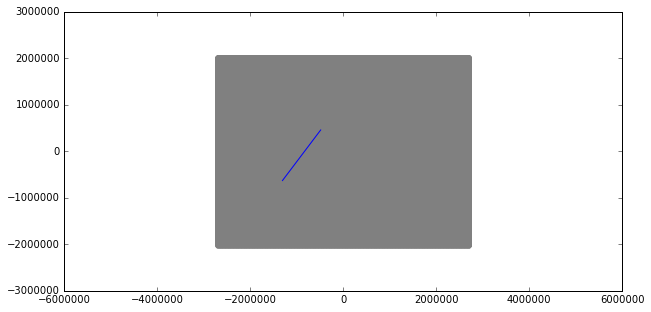

In [28]:
plt.figure(figsize=(10,5));
plt.plot(X,Y,'.',c='0.5'); # plot the WRF LCC lat longs
plt.plot(bx_x,bx_y); # plot the corners of dom's box, looks ok
plt.axis('equal')

In [29]:
print "Dom's box longs: "+str(bx_y)
print "Dom's box lats: "+str(bx_x)

Dom's box longs: [-629423.95809243  458859.27923162]
Dom's box lats: [-1306471.27248405  -483968.19202259]


In [30]:
pts = [(-1122174.3745043932, 531025.5694791628),
 (-483968.1920225884, 458859.27923161554),
 (-563451.2372043831, -713442.2596971219),
 (-1306471.272484048, -629423.9580924311)]

In [31]:
x,y = zip(*pts)

In [32]:
xmax = np.max(x)
xmin = np.min(x)
ymax = np.max(y)
ymin = np.min(y)

In [33]:
print xmax
print xmin
print ymax
print ymin

-483968.192023
-1306471.27248
531025.569479
-713442.259697


In [34]:
# make a matrix of zeros and fill Dom's box with ones
db = np.zeros_like(X)
db[Y>=ymin] = 1
db[Y>ymax] = 0
db[X<xmin] = 0
db[X>xmax] = 0

In [36]:
bx_longs= np.array([-112.25,-112.25,-104.125,-104.125,-112.25])
bx_lats = np.array([33.0,43.75,43.75,33.0,33.0])

xx,yy = proj.transform(p1,p2,bx_longs,bx_lats)

(-753442.25969712192, 571025.5694791628)

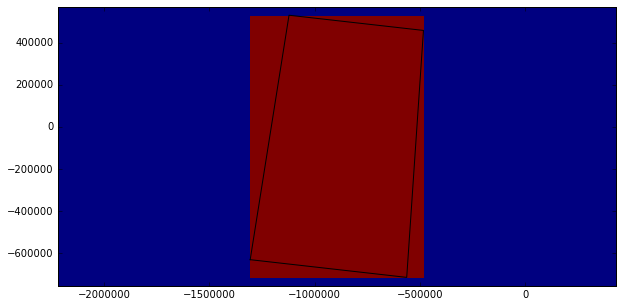

In [41]:
# Plot the WRF CONUS domain and Dom's domain within it
plt.figure(figsize=(10,5));
plt.pcolormesh(X,Y,db);
plt.plot(xx,yy,'k',lw=1)
plt.axis('equal');
plt.xlim(xx.min()-40000,xx.max()+40000)
plt.ylim(yy.min()-40000,yy.max()+40000)

In [42]:
# get indicies for Dom's domain
yind,xind = np.where(db==1)

In [43]:
# compute the index values for the grid cells covering dom's box
print "Minimum Y index: "+str(np.min(yind))+" (south_north)" # min x
print "Maximum Y index: "+str(np.max(yind))+" (south_north)" # max x
print "Minimum X index: "+str(np.min(xind))+" (west_east)" # min y
print "Maximum X index: "+str(np.max(xind))+" (west_east)" # max y
print "Use these indicies to crop the thinned netCDF files on the south_north and west_east dimensions"

Minimum Y index: 329 (south_north)
Maximum Y index: 639 (south_north)
Minimum X index: 353 (west_east)
Maximum X index: 558 (west_east)
Use these indicies to crop the thinned netCDF files on the south_north and west_east dimensions


In [3]:
import gdal

In [5]:
# load DEM`
fl = '/Users/barnhatb/Downloads/To_Dominik_2016_02_12/geo_em_hgt_m/dblbnd.adf'
d = gdal.Open(fl)
dem = np.array(d.GetRasterBand(1).ReadAsArray())

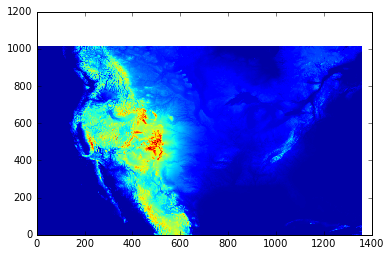

In [7]:
plt.pcolormesh(np.flipud(dem))

In [ ]:
# print as a geotiff

outpathP = out+'precipitation_'+yy+'_'+mm+'_'+dd+'.tif' # generate the precipitation output path

output_prec = gdal.GetDriverByName('GTiff').Create(outpathP,n,m,1,gdal.GDT_Float32) # open the output file
output_prec.SetGeoTransform(transform) # set coordinates
output_prec.SetProjection(srs) # set projection


output_prec.GetRasterBand(1).WriteArray(P_out) # write precipitation array to raster